# Exploring NSL-KDD dataset

The purpose of this notebook is a basic exploration of the NSL-KDD dataset. Here are the goals of this exploration:
* Gain a basic understanding of the data set
* Look at how the data set might be used to predict network anomalies or attacks
* Walk through some fundemental concepts of building machine learning models

Throughout we'll do some work by hand that could be done in more effective ways using delivered functionality within sci-kit. The intent here is to be more deliberate about the process of understanding what we're doing and why. We will look at how to approach some of these problems using the built-in toools in a later notebook.

In [1]:
# module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Welcome!')

Welcome!


# Data extraction
We'll start by fetching our data set. There's a few options for data sets here, so we'll build a couple paths and use comments to pick and choose the ones we want.

In [2]:
# fetch the training file
file_path_20_percent = 'nsl-kdd/KDDTrain+_20Percent.txt'
file_path_full_training_set = 'nsl-kdd/KDDTrain+.txt'
file_path_test = 'nsl-kdd/KDDTest+.txt' 

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

The data set doesn't include column names, so let's add them.

In [3]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


# Data transformations
The first transformations that we'll want to do are around the attack field. We'll start by adding a column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack. 

In [4]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


In [5]:
np.shape(df)

(125972, 44)

In [6]:
set(df['protocol_type'])

{'icmp', 'tcp', 'udp'}

In [7]:
set(df['attack'])

{'back',
 'buffer_overflow',
 'ftp_write',
 'guess_passwd',
 'imap',
 'ipsweep',
 'land',
 'loadmodule',
 'multihop',
 'neptune',
 'nmap',
 'normal',
 'perl',
 'phf',
 'pod',
 'portsweep',
 'rootkit',
 'satan',
 'smurf',
 'spy',
 'teardrop',
 'warezclient',
 'warezmaster'}

In [8]:
set(df['service'])

{'IRC',
 'X11',
 'Z39_50',
 'aol',
 'auth',
 'bgp',
 'courier',
 'csnet_ns',
 'ctf',
 'daytime',
 'discard',
 'domain',
 'domain_u',
 'echo',
 'eco_i',
 'ecr_i',
 'efs',
 'exec',
 'finger',
 'ftp',
 'ftp_data',
 'gopher',
 'harvest',
 'hostnames',
 'http',
 'http_2784',
 'http_443',
 'http_8001',
 'imap4',
 'iso_tsap',
 'klogin',
 'kshell',
 'ldap',
 'link',
 'login',
 'mtp',
 'name',
 'netbios_dgm',
 'netbios_ns',
 'netbios_ssn',
 'netstat',
 'nnsp',
 'nntp',
 'ntp_u',
 'other',
 'pm_dump',
 'pop_2',
 'pop_3',
 'printer',
 'private',
 'red_i',
 'remote_job',
 'rje',
 'shell',
 'smtp',
 'sql_net',
 'ssh',
 'sunrpc',
 'supdup',
 'systat',
 'telnet',
 'tftp_u',
 'tim_i',
 'time',
 'urh_i',
 'urp_i',
 'uucp',
 'uucp_path',
 'vmnet',
 'whois'}

In [9]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [10]:
df['attack'].value_counts()

normal             67342
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

In [11]:
#Finding categorical features
num_cols = df._get_numeric_data().columns

cate_cols = list(set(df.columns)-set(num_cols))

cate_cols

['service', 'protocol_type', 'attack', 'flag']

In [12]:
def bar_graph(feature):
    df[feature].value_counts().plot(kind="bar")

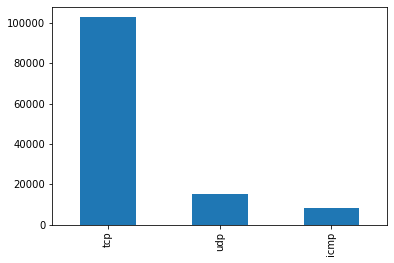

In [13]:
bar_graph('protocol_type')

In [14]:
attacks_types = {
    'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
'saint':'probe'
}

df['Attack Type'] = df.attack.map(lambda r:attacks_types[r[:]])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,Attack Type
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,dos
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,dos


In [15]:
attacks_types = {
    'normal': 'normal',
'back': 'dos',
'buffer_overflow': 'u2r',
'ftp_write': 'r2l',
'guess_passwd': 'r2l',
'imap': 'r2l',
'ipsweep': 'probe',
'land': 'dos',
'loadmodule': 'u2r',
'multihop': 'r2l',
'neptune': 'dos',
'nmap': 'probe',
'perl': 'u2r',
'phf': 'r2l',
'pod': 'dos',
'portsweep': 'probe',
'rootkit': 'u2r',
'satan': 'probe',
'smurf': 'dos',
'spy': 'r2l',
'teardrop': 'dos',
'warezclient': 'r2l',
'warezmaster': 'r2l',
'saint':'probe',
'mscan':'probe',
'apache2':'dos',
    'snmpgetattack':'r2l',
    'processtable':'dos',
    'httptunnel':'u2r',
    'ps':'u2r',
    'snmpguess':'r2l',
    'mailbomb':'dos',
    'named':'r2l',
    'sendmail':'r2l',
    'xterm':'u2r',
    'worm':'r2l',
    'xlock':'r2l',
    'xsnoop':'r2l',
    'sqlattack':'u2r',
    'udpstorm':'dos'
}
test_df['Attack Type']=test_df.attack.map(lambda r:attacks_types[r[:]])

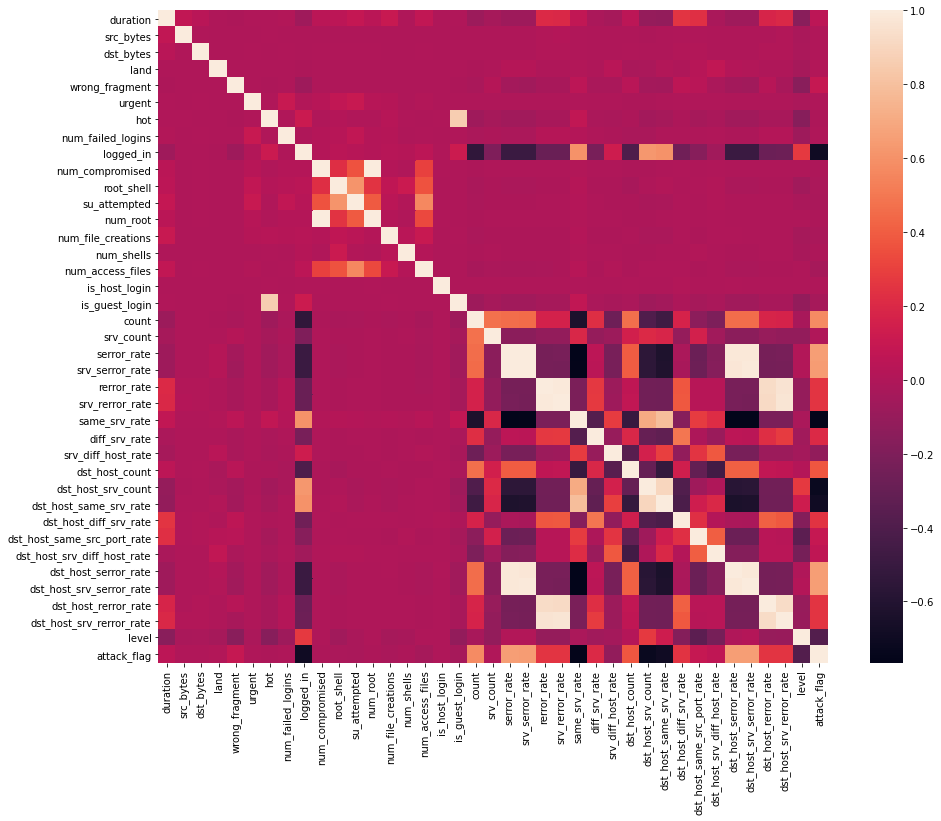

In [16]:
df = df.dropna('columns')# drop columns with NaN

df = df[[col for col in df if df[col].nunique() > 1]]# keep columns where there are more than 1 unique values

corr = df.corr()

plt.figure(figsize=(15,12))

sns.heatmap(corr)

plt.show()

In [17]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,Attack Type
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,dos
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,dos


In [18]:
#This variable is highly correlated with num_compromised and should be ignored for analysis.
df.drop('num_root',axis = 1,inplace = True)

df.drop('srv_serror_rate',axis = 1,inplace = True)

df.drop('srv_rerror_rate',axis = 1, inplace=True)


df.drop('dst_host_srv_serror_rate',axis = 1, inplace=True)


df.drop('dst_host_serror_rate',axis = 1, inplace=True)

df.drop('dst_host_rerror_rate',axis = 1, inplace=True)


df.drop('dst_host_srv_rerror_rate',axis = 1, inplace=True)


df.drop('dst_host_same_srv_rate',axis = 1, inplace=True)


In [19]:
#This variable is highly correlated with num_compromised and should be ignored for analysis.
test_df.drop('num_root',axis = 1,inplace = True)

test_df.drop('srv_serror_rate',axis = 1,inplace = True)

test_df.drop('srv_rerror_rate',axis = 1, inplace=True)


test_df.drop('dst_host_srv_serror_rate',axis = 1, inplace=True)


test_df.drop('dst_host_serror_rate',axis = 1, inplace=True)

test_df.drop('dst_host_rerror_rate',axis = 1, inplace=True)


test_df.drop('dst_host_srv_rerror_rate',axis = 1, inplace=True)


test_df.drop('dst_host_same_srv_rate',axis = 1, inplace=True)

In [20]:
df.shape

(125972, 36)

In [21]:
test_df = test_df.dropna('columns')# drop columns with NaN

test_df = test_df[[col for col in test_df if test_df[col].nunique() > 1]]#
test_df.shape

(22543, 36)

In [22]:
df_std = df.std()
df_std = df_std.sort_values(ascending = True)
df_std

is_host_login                  2.817494e-03
land                           1.408613e-02
urgent                         1.436608e-02
num_shells                     2.218122e-02
root_shell                     3.660299e-02
su_attempted                   4.515456e-02
num_failed_logins              4.523932e-02
is_guest_login                 9.661271e-02
num_access_files               9.936995e-02
dst_host_srv_diff_host_rate    1.125642e-01
diff_srv_rate                  1.803150e-01
dst_host_diff_srv_rate         1.889225e-01
wrong_fragment                 2.535310e-01
srv_diff_host_rate             2.598314e-01
dst_host_same_src_port_rate    3.089984e-01
rerror_rate                    3.204366e-01
same_srv_rate                  4.396236e-01
serror_rate                    4.464567e-01
num_file_creations             4.839370e-01
logged_in                      4.890107e-01
attack_flag                    4.988048e-01
hot                            2.149977e+00
level                          2

In [23]:
test_df_std = test_df.std()
test_df_std = test_df_std.sort_values(ascending = True)
test_df_std

land                                0.017619
su_attempted                        0.021061
is_host_login                       0.022085
urgent                              0.036474
num_shells                          0.048015
root_shell                          0.049335
num_access_files                    0.067831
dst_host_srv_diff_host_rate         0.085396
wrong_fragment                      0.142602
num_failed_logins                   0.150331
is_guest_login                      0.166214
dst_host_diff_srv_rate              0.220722
srv_diff_host_rate                  0.253550
diff_srv_rate                       0.259143
serror_rate                         0.295373
dst_host_same_src_port_rate         0.306274
same_srv_rate                       0.412479
rerror_rate                         0.416096
attack_flag                         0.495196
logged_in                           0.496661
num_file_creations                  0.676857
hot                                 0.928448
level     

In [24]:
#protocol_type feature mapping
pmap = {'icmp':0,'tcp':1,'udp':2}
df['Protocol_type'] = df.protocol_type.map(lambda r:pmap[r[:]])
df.drop('protocol_type',axis=1,inplace=True)

In [25]:
#flag feature mapping
fmap = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6 ,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
df['flag'] = df['flag'].map(fmap)

In [26]:
df.drop('service',axis=1,inplace=True)
test_df.drop('service',axis=1,inplace=True)

In [27]:
test_df['Protocol_type'] = test_df.protocol_type.map(lambda r:pmap[r[:]])
test_df.drop('protocol_type',axis=1,inplace=True)
test_df['flag'] = test_df['flag'].map(fmap)

In [28]:
df.shape

(125972, 35)

In [29]:
df.drop('level',axis = 1,inplace= True)

In [30]:
df.drop('attack_flag',axis = 1,inplace= True)

In [31]:
test_df.drop('attack_flag',axis = 1,inplace= True)
test_df.drop('level',axis = 1,inplace= True)

In [32]:
test_df.shape

(22543, 33)

In [33]:
df.dtypes

duration                         int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
rerror_rate                    float64
same_srv_rate                  float64
diff_srv_rate                  float64
srv_diff_host_rate             float64
dst_host_count           

### Modelling

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [158]:

# Target variable and train set
Y = df[['Attack Type']]
X = df.drop(['Attack Type',], axis=1)

sc = MinMaxScaler()
X = sc.fit_transform(X)

# Split test and train data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(84401, 31) (41571, 31)
(84401, 1) (41571, 1)


In [159]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
import time
train_time=[]
test_time=[]
accuracy=[]

In [160]:
model1 = GaussianNB()
start_time = time.time()
model1.fit(X_train, Y_train.values.ravel())
end_time = time.time()

train_time.append(end_time-start_time)

In [161]:
start_time = time.time()
Y_test_pred1 = model1.predict(X_test)
end_time = time.time()
test_time.append(end_time-start_time)

In [162]:
print("Train score is:", model1.score(X_train, Y_train))
print("Test score is:",model1.score(X_test,Y_test))
accuracy.append(model1.score(X_test,Y_test))

Train score is: 0.4699588867430481
Test score is: 0.4763416804984244


In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
model2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
start_time = time.time()
model2.fit(X_train, Y_train.values.ravel())
end_time = time.time()
train_time.append(end_time-start_time)
start_time = time.time()
Y_test_pred2 = model2.predict(X_test)
end_time = time.time()
test_time.append(end_time-start_time)

In [82]:
print("Train score is:", model2.score(X_train, Y_train))
print("Test score is:",model2.score(X_test,Y_test))
accuracy.append(model2.score(X_test,Y_test))

Train score is: 0.9245862015852893
Test score is: 0.9239854706405908


In [83]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier(n_estimators=30)
start_time = time.time()
model3.fit(X, Y.values.ravel())
end_time = time.time()
train_time.append(end_time-start_time)
start_time = time.time()
Y_test_pred3 = model3.predict(X_test)
end_time = time.time()
test_time.append(end_time-start_time)
print("Train score is:", model3.score(X_train, Y_train))
print("Test score is:",model3.score(X_test,Y_test))
accuracy.append(model3.score(X_test,Y_test))

Train score is: 0.9996090093719269
Test score is: 0.9997113372302807


In [84]:
from sklearn.linear_model import LogisticRegression
model4 = LogisticRegression()
start_time = time.time()
model4.fit(X_train, Y_train.values.ravel())
end_time = time.time()
train_time.append(end_time-start_time)
start_time = time.time()
Y_test_pred4 = model4.predict(X_test)
end_time = time.time()
test_time.append(end_time-start_time)
print("Train score is:", model4.score(X_train, Y_train))
print("Test score is:",model4.score(X_test,Y_test))
accuracy.append(model4.score(X_test,Y_test))

Train score is: 0.9541711591094892
Test score is: 0.9511678814558225


C:\Users\ASUS\Desktop\sample_project\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
from sklearn.svm import SVC
model5 = SVC(gamma = 'scale')
start_time = time.time()
model5.fit(X_train, Y_train.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)
train_time.append(end_time-start_time)
start_time = time.time()
Y_test_pred5 = model5.predict(X_test)
end_time = time.time()
test_time.append(end_time-start_time)
print("Testing time: ",end_time-start_time)
print("Train score is:", model5.score(X_train, Y_train))
print("Test score is:", model5.score(X_test,Y_test))
accuracy.append(model5.score(X_test,Y_test))

Training time:  46.48429989814758
Testing time:  43.05670881271362
Train score is: 0.9819433419035319
Test score is: 0.9806114839671887


In [87]:
Y_test['Attack Type'].value_counts()

normal    22099
dos       15270
probe      3866
r2l         316
u2r          20
Name: Attack Type, dtype: int64

In [88]:
print(len(Y_test_pred2[Y_test_pred2=="dos"]))

14115


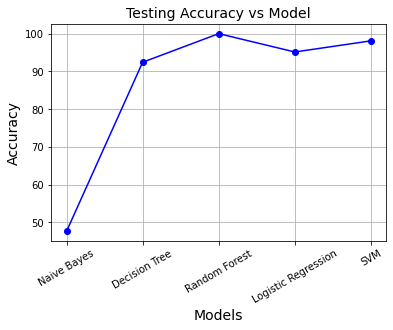

In [97]:
Models = ["Naive Bayes","Decision Tree","Random Forest","Logistic Regression","SVM"]
for i in range(0,5):
    accuracy[i]=accuracy[i]*100

plt.plot(Models, accuracy, color='blue', marker='o',)
plt.title('Testing Accuracy vs Model', fontsize=14)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=30)
plt.grid(True)
plt.savefig("Testing Accuracy vs Model.png", bbox_inches = 'tight')

In [95]:
accuracy

[47.634168049842444,
 92.39854706405907,
 99.97113372302807,
 95.11678814558225,
 98.06114839671885]

In [110]:
attack=np.array(Y_test['Attack Type'].value_counts())

In [99]:
len(Y_test_pred1[Y_test_pred1=="normal"])

1389

In [146]:
from sklearn.metrics import classification_report
actual=Y_test
predicted=Y_test_pred3
matrix1 = confusion_matrix(actual,predicted, labels=['normal','r2l','probe','dos','u2r'])
print('Confusion matrix : \n',matrix1)

# outcome values order in sklearn


# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=['normal','r2l','probe','dos','u2r'])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[22094     0     4     1     0]
 [    1   315     0     0     0]
 [    5     0  3861     0     0]
 [    0     0     0 15270     0]
 [    1     0     0     0    19]]
Classification report : 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00     22099
         r2l       1.00      1.00      1.00       316
       probe       1.00      1.00      1.00      3866
         dos       1.00      1.00      1.00     15270
         u2r       1.00      0.95      0.97        20

    accuracy                           1.00     41571
   macro avg       1.00      0.99      0.99     41571
weighted avg       1.00      1.00      1.00     41571



In [140]:
predicted_labels=[]
for i in range(0,5):
    for j in range(0,5):
        if(i==j):
            predicted_labels.append(matrix1[i][j])
        

In [141]:
predicted_labels

[21864, 245, 3707, 14943, 6]

In [142]:
attack - predicted_labels

array([235,  71, 159, 327,  14], dtype=int64)

In [143]:
attack

array([22099,   316,  3866, 15270,    20])

In [115]:
attack=[]
attack.append(22099)
attack.append(316)
attack.append(3866)
attack.append(15270)
attack.append(20)

In [144]:
attack - predicted_labels

array([235,  71, 159, 327,  14], dtype=int64)

In [117]:
attack=np.array(attack)

In [145]:
j=0
for i in predicted_labels:
    print((i/attack[j])*100)
    j=j+1

98.93660346622019
77.53164556962025
95.88722193481635
97.85854616895874
30.0


In [126]:
attack

array([22099,   316,  3866, 15270,    20])

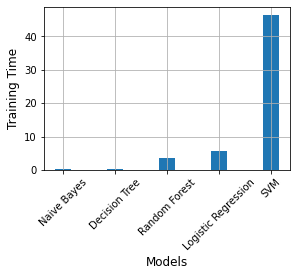

In [153]:
Models = ["Naive Bayes","Decision Tree","Random Forest","Logistic Regression","SVM"]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.xticks(rotation=45)
plt.grid(True)
plt.bar(Models,train_time,width=0.3)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Training Time', fontsize=12)
plt.savefig("Training Time vs Model.png", bbox_inches = 'tight')

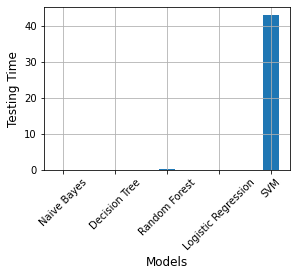

In [154]:
Models = ["Naive Bayes","Decision Tree","Random Forest","Logistic Regression","SVM"]
f = plt.figure(figsize=(15,3),num=10)
plt.subplot(131)
plt.xticks(rotation=45)
plt.grid(True)
plt.bar(Models,test_time,width=0.3)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Testing Time', fontsize=12)
plt.savefig("Testing Time vs Model.png", bbox_inches = 'tight')

In [155]:
train_time

[0.1450047492980957,
 0.3570256233215332,
 3.6565093994140625,
 5.6284520626068115,
 46.48429989814758]

In [156]:
test_time

[0.11701250076293945,
 0.008001089096069336,
 0.1567981243133545,
 0.005999565124511719,
 43.05670881271362]